# Exploring population density per county

This notebook will explore the California census data per county,
especially population density.
Along the way, there will be natural improvements to make in new areas:
* Log scales
* Scatterplots
* Color bars

We will use [Seaborn](https://seaborn.pydata.org/) for one histogram example,
but it can be skipped fairly easily.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('census-data/counties.csv', index_col=0)
df.head()

,NAME,area,estimate,ratio,density
GEOID,,,,,
6075,"San Francisco County, California",232.497093,757415,1.040857,3257.739650
6081,"San Mateo County, California",743.365017,607919,0.958609,817.793393
6001,"Alameda County, California",823.373527,1312727,0.947308,1594.327432
6039,"Madera County, California",2161.238868,112580,0.897362,52.090494
6107,"Tulare County, California",4868.434787,318740,0.979924,65.470734


# Default histograms

We've all seen histograms like this,
and you probably recognize that this will likely benefit from a log scale.

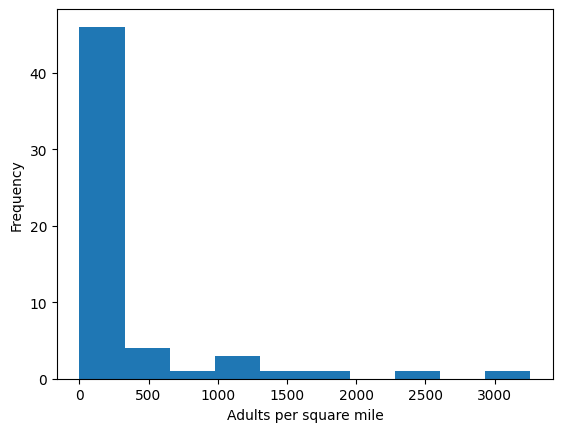

In [3]:
ax = df['density'].plot(kind='hist')
ax.set_xlabel('Adults per square mile');

# Log scales and a Seaborn example

It turns out there are several slightly unpleasant ways to attempt this
with basic pandas and matplotlib.
But Seaborn can take care of it very nicely.
This is a great example of how the same "mix and match" style
of combining explicit matplotlib operations with other libraries
can yield great results.

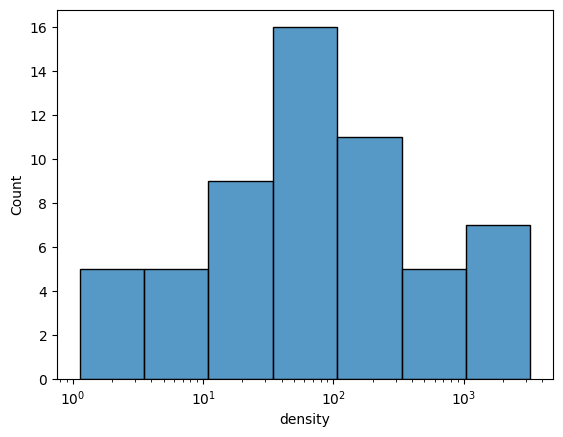

In [4]:
# Try several ways to get a log scale

# You might try this... but no.
#df['density'].plot(kind='hist', logx=True);

# This one is ok, but does not give useful x tick labels
#plt.hist(np.log10(df['density']));

# This one is better, but we are doing a lot of work here..
#hist, bins = np.histogram(np.log10(df['density']))
#plt.stairs(hist, edges=10**bins, fill=True)  # <-- our old friend the stairs plot
#plt.xscale('log');

# It turns out that seaborn has a better way!
#https://seaborn.pydata.org/examples/histogram_stacked.html
sns.histplot(df, x='density', log_scale=True);

## Fancy tick label control

Now let's say we want to change how the tick labels are formatted.
This cell includes several ways to do it - progressively more fancy (and reusable).
This is a great example of the trade-offs you are likely to make between fast and readable,
or robust and resusable.

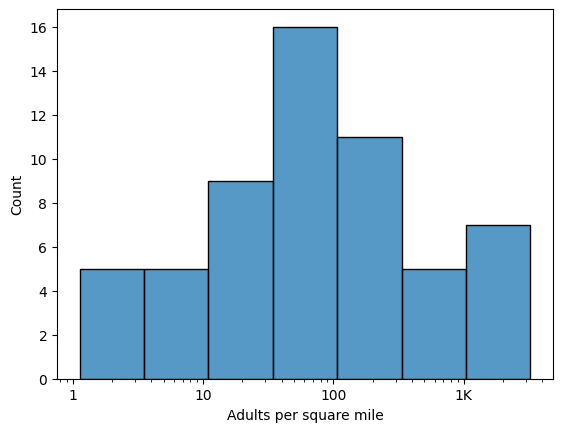

In [5]:
ax = sns.histplot(df, x='density', log_scale=True)
ax.set_xlabel('Adults per square mile')

# Try setting only the tick labels - what is going on?
#print(ax.get_xticks())
#ax.set_xticks([1, 10, 100, 10**3])
#ax.set_xticklabels(["1", "10", "100", "1K"]);

# It is possible to define a function that generates our desired labels from the tick values
# https://matplotlib.org/stable/gallery/ticks/tick_labels_from_values.html
def my_log_label_generator(tick_val, tick_pos):
    # https://stackoverflow.com/questions/579310/formatting-long-numbers-as-strings/45846841#45846841
    from math import log, floor
    if tick_val > 10**11:
        raise Exception("I did not plan for numbers greater than 100 billion")
    elif tick_val < 1:
        #raise Exception("I did not plan for numbers less than 1")
        return f'{tick_val}'
    suffixes = ['', 'K', 'M', 'B']
    suffix_index = floor(log(tick_val, 10**3))
    return f'{tick_val/(10**(3*suffix_index)):.0f}{suffixes[suffix_index]}'

# Try this with a function that cannot handle values less than 1
# You can fix it by trimming the ticks yourself like below...
# But it is usually better to expand the range handled by your function
#ax.set_xticks([t for t in ax.get_xticks() if t > ax.get_xlim()[0] and t < ax.get_xlim()[1]])

ax.xaxis.set_major_formatter(my_log_label_generator);

In [6]:
# Notice that in addition to our normal axes object:
print(f"We use {type(ax)} all the time.")
# We're also using the `set_major_formatter` method on the individual x-axis object:
print(f"But this is the first time we have encountered {type(ax.xaxis)} directly.")

We use <class 'matplotlib.axes._axes.Axes'> all the time.
But this is the first time we have encountered <class 'matplotlib.axis.XAxis'> directly.


# Default scatterplots

Population density is just population divided by area - let's look at those individually.
First, plot a non-log-scale scatterplot just to remind ourselves how bad it can look.

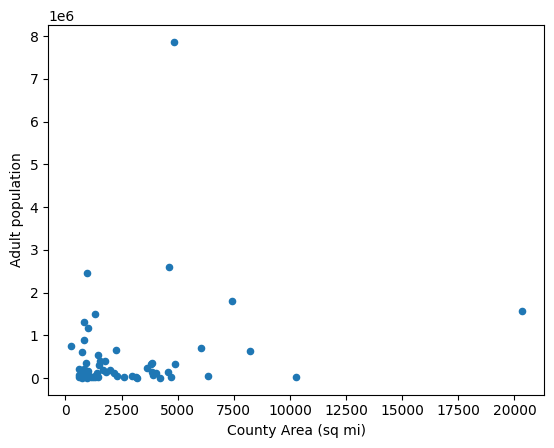

In [7]:
df.plot('area', 'estimate', kind = 'scatter',
        xlabel = 'County Area (sq mi)', ylabel = 'Adult population')
plt.savefig('plots/part-3-before.png', bbox_inches='tight')

Now let's use some of the same log scale tricks we used on the histogram.
Part of our job is easier, because the `logx` and `logy` arguments to `df.plot` do what we expect this time.

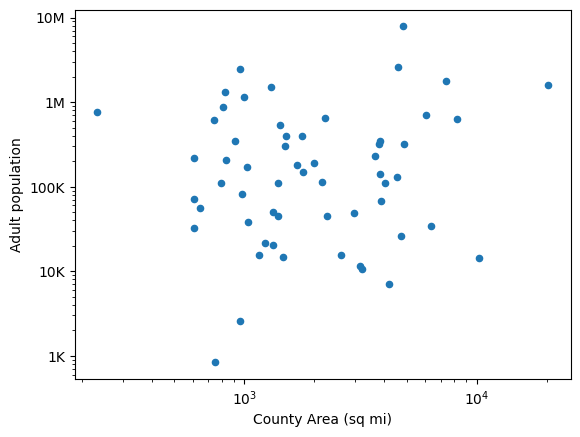

In [8]:
ax = df.plot(
    'area', 'estimate', kind = 'scatter',
    logx = True, logy = True,
    xlabel = 'County Area (sq mi)', ylabel = 'Adult population'
)

# Notice how a little more work up front is paying off now
ax.yaxis.set_major_formatter(my_log_label_generator);

# Colorbars

We know the most dense counties are in the top left of this scatterplot,
but it's really hard to pick any two counties and know which one is more dense.
So, we want to visualize the density explicitly here.

This is where we encounter colormaps and colorbars for the first time:
https://matplotlib.org/stable/tutorials/colors/colormaps.html.
Good colormap choice is a very nuanced topic,
and while the matplotlib guide provides a good starting point,
it is worth following some of their references to read more.

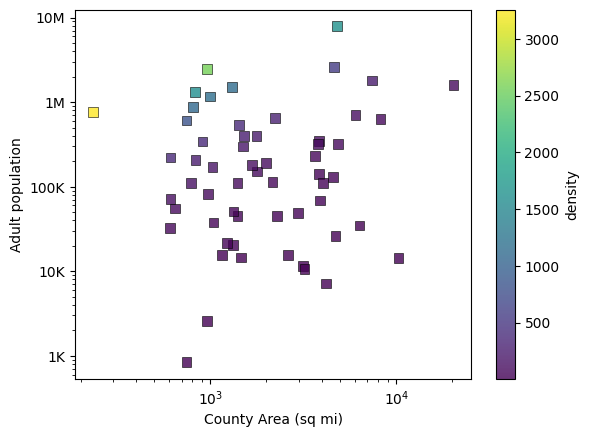

In [9]:
# Try switching to "classic" style to see the defaults from the bad old days
# There are many, many blogs hating on the old default colormap "jet"; here is one:
# https://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/
import matplotlib as mpl
import matplotlib.style
#mpl.style.use('classic')
mpl.style.use('default')

# Uncomment the "norm" and "cmap" arguments to do some basic customization
# Try out other marker styling options as well
ax = df.plot(
    'area', 'estimate', kind = 'scatter',
    edgecolor='k', linewidth=0.5, s=7**2, marker='s', alpha=0.8,
    logx = True, logy = True, c = 'density', #norm = 'log', cmap = 'Purples',
    xlabel = 'County Area (sq mi)', ylabel = 'Adult population'
)
ax.yaxis.set_major_formatter(my_log_label_generator);

There is not an easy way to relabel the colorbar in pandas,
short of renaming the column itself.
Let's take this as an opportunity to do the same plot explicitly in matplotlib.

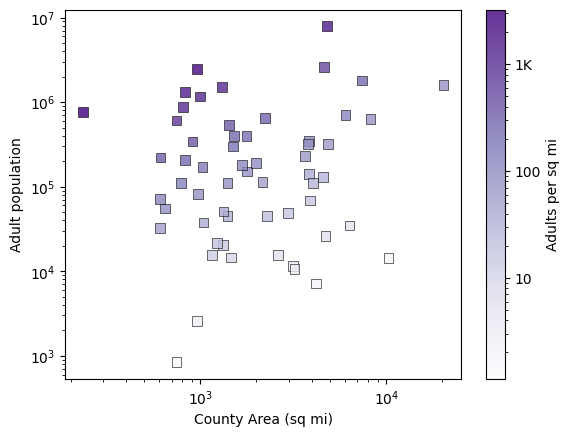

In [10]:
fig, ax = plt.subplots()
sc = ax.scatter(
    df['area'], df['estimate'],
    edgecolor='k', linewidth=0.5, s=7**2, marker='s', alpha=0.8,
    c = df['density'], norm = 'log', cmap = 'Purples'
)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('County Area (sq mi)')
ax.set_ylabel('Adult population')

# Colorbar placement can get complicated, but here we just associate it with our single ax
# See https://matplotlib.org/stable/gallery/subplots_axes_and_figures/colorbar_placement.html for more
cb = fig.colorbar(sc, ax=ax)
cb.set_label('Adults per sq mi')
cb.ax.yaxis.set_major_formatter(my_log_label_generator);

# An aside on matplotlib objects

The previous cell had two new things, `sc` and `cb`,
which are not quite as common as `ax` but still a common naming convention.
But what are they?
Can't we use the "mix and match" strategy to use them together with `df.plot()`?
You can, but it's not always worth it.

In [11]:
print(f"New thing returned by doing a scatterplot: {type(sc)}")
print(f"New thing returned by adding a colorbar: {type(cb)}")
print(f"The thing inside 'cb.ax' is our old friend: {type(cb.ax)}")

New thing returned by doing a scatterplot: <class 'matplotlib.collections.PathCollection'>
New thing returned by adding a colorbar: <class 'matplotlib.colorbar.Colorbar'>
The thing inside 'cb.ax' is our old friend: <class 'matplotlib.axes._axes.Axes'>


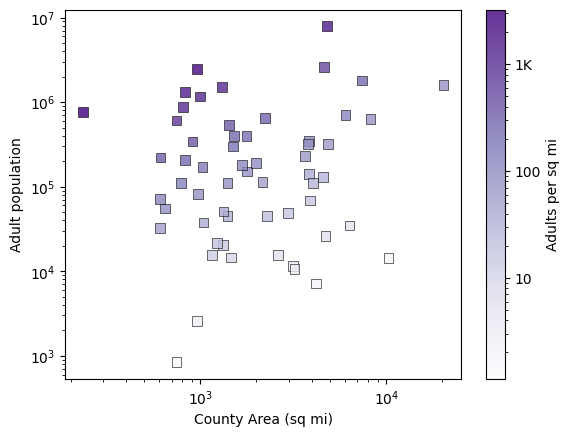

In [12]:
# Now let's try to do this using pandas, and extracting the colorbar to operate on
ax = df.plot(
    'area', 'estimate', kind = 'scatter',
    edgecolor='k', linewidth=0.5, s=7**2, marker='s', alpha=0.8,
    logx = True, logy = True, c = 'density', norm = 'log', cmap = 'Purples',
    xlabel = 'County Area (sq mi)', ylabel = 'Adult population'
)

# Here we have to extract the equivalent of "sc" in the previous cell
# This looks simple, but is potentially quite painful, especially for complex plots!
# Different plot types may not house the relevant artist objects in the "collections" attribute
# There no great way to decide which artist to use if there is more than one
# I would consider this a pretty advanced application of the "mix and match" principle
sc = ax.collections[0]
cb = sc.colorbar

# Once you have the relevant object, life is good.
cb.set_label('Adults per sq mi')
cb.ax.yaxis.set_major_formatter(my_log_label_generator);

# Exploring Male to Female ratio

For the last major plot, let's explore the ratio of Male and Female population in each county.
We might start with a histogram, but it turns out there are a couple of interesting outliers,
so let's do an eventplot.
Since I'm really only interested in 1 dimension,
it's also a good situation for tweaking the aspect ratio of the figure.

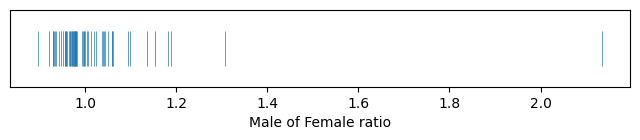

In [13]:
fig, ax = plt.subplots(figsize = (8,1))
ax.eventplot(df['ratio'], lw=0.5)
ax.set_xlabel('Male of Female ratio')
ax.set_yticks([]);

Based on this, I definitely want to treat the most extreme county as an outlier.
I'd like to keep track of the second most extreme one as well, though it is closer to the rest.
(It turns out that they both have significant California state prison populations.)

In [14]:
i_outlier2, i_outlier1 = df['ratio'].argsort()[-2:]
df.iloc[[i_outlier1, i_outlier2]]

,NAME,area,estimate,ratio,density
GEOID,,,,,
6035,"Lassen County, California",4719.291478,26216,2.134385,5.555071
6031,"Kings County, California",1400.633661,109652,1.307152,78.287423


For the final plot, we will add a few new things:
* Change our colormap choices to fit the data
    * Use a diverging color scheme instead of sequential
    * Manually trim the range to exclude the outliers
    * Also ensure the center color represents where Male and Female populations are equal
* Annotate lines of constant population density, since we no longer visualize it via colormap
* Annotate the two outlier points

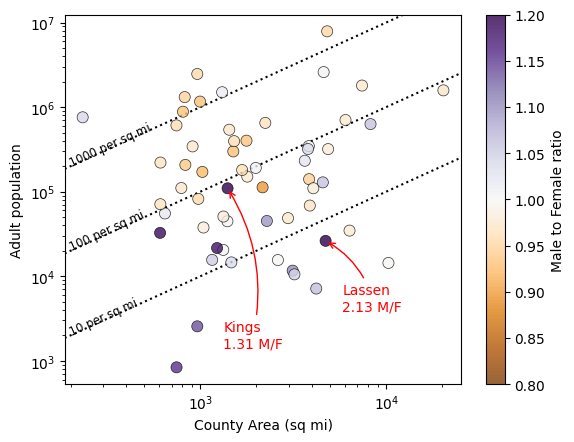

In [15]:
fig, ax = plt.subplots()
sc = ax.scatter(
    df['area'], df['estimate'],
    edgecolor='k', linewidth=0.5, s=8**2, marker='o', alpha=0.8,
    c = df['ratio'], cmap = 'PuOr', vmin = 0.8, vmax = 1.2
)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('County Area (sq mi)')
ax.set_ylabel('Adult population')
cb = fig.colorbar(sc, ax=ax)
cb.set_label('Male to Female ratio')

# https://matplotlib.org/stable/gallery/text_labels_and_annotations/text_rotation_relative_to_line.html
xlimits = np.array(ax.get_xlim())
ylimits = np.array(ax.get_ylim())
for density in [10, 100, 1000]:
    ax.plot(xlimits, density*xlimits, ls=':', c='k', zorder=-1)
    angle = np.rad2deg(np.arctan(density))
    ax.text(xlimits[0], density*xlimits[0], f'  {density} per sq mi',
            fontsize='small', rotation=angle, rotation_mode='anchor',
            transform_rotates_text=True)
ax.set_xlim(xlimits)
ax.set_ylim(ylimits)

# Set some arrow properties for the outlier annotation
outlier_textprops = dict(textcoords = 'axes fraction', color = 'r')
outlier_arrowprops = dict(color = 'r', arrowstyle = '->', connectionstyle = 'arc3,rad=0.2')

# Annotate first outlier
cty1 = df.iloc[i_outlier1]
ax.annotate(f"{cty1['NAME'].split()[0]}\n{cty1['ratio']:.2f} M/F", (cty1['area'], cty1['estimate']),
            xytext = (0.7, 0.2), arrowprops = outlier_arrowprops, **outlier_textprops)

# Annotate second outlier
cty2 = df.iloc[i_outlier2]
ax.annotate(f"{cty2['NAME'].split()[0]}\n{cty2['ratio']:.2f} M/F", (cty2['area'], cty2['estimate']),
            xytext = (0.4, 0.1), arrowprops = outlier_arrowprops, **outlier_textprops)

# Save the final plot!
plt.savefig('plots/part-3-after.png', bbox_inches='tight')

# Where to go from here?

We have this very fancy plot,
where I notice the trend of Male to Female adult population ratio
seems to depend on population density.
It was a great excuse to showcase some fancy annotation practices,
especially with the outliers.

But when it comes to effective visual communication, we have probably gone too far!

We've built ourselves a great **exploratory** plot,
but it's time to step back and think about the best **explanatory** plots.
It may be that total population and county area are just distractions,
and what really matters is population density.
So, let's start over with something simpler like the below.
Where would you take it from there?

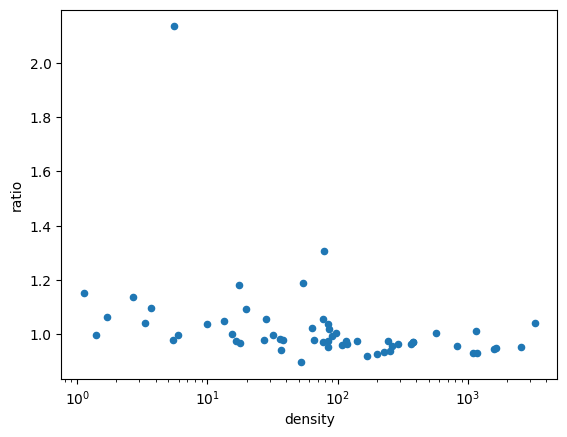

In [16]:
ax = df.plot.scatter('density', 'ratio', logx=True);

# Let's say I want to exclude the outliers, and fit a linear model on my suspected trend
# Leaving aside whether my treatment is analytically appropriate for the moment, I might start like this:
#ax = df.drop(df.iloc[[i_outlier1, i_outlier2]].index, axis=0).plot.scatter('density', 'ratio', logx=True);

# Now what if I want to add back some annotation for the outliers on this plot?
# What other improvements could I make?

# You might take this plot in a completely different direction...
# ..e.g. keep the outliers, but stretch the aspect ratio to give more room on the y-axis.
# Or, use multiple plots or panels to show each version.
# The sky is the limit!